In [1]:
from pathlib import Path

import cmocean
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from scipy import integrate as si

plt.style.use("../paper.mplstyle")

In [2]:
def to_xarray(df: pd.DataFrame, df_head: pd.DataFrame, nfreq: int = 10001, method: str = "nearest"):
    xs = df.index.to_numpy()
    zs = np.array([df[col].to_numpy() for col in df.columns if col.startswith("Y")], dtype=float)
    ys = df_head.Angles_8027.to_numpy()

    zs[np.isnan(zs)] = 0

    # attrs = {f"direction{ii+1}": d for ii, d in enumerate(directions)}
    coords = {"angle": ys, "frequency": xs}
    dims = coords.keys()
    kw = {"dims": dims, "coords": coords}  # , "attrs": attrs}

    da = xr.DataArray(zs, **kw)

    # intepolate to regular grid
    _xmin, _xmax = float(da.frequency.min()), float(da.frequency.max())
    _x = np.linspace(_xmin, _xmax, nfreq)
    da = da.interp(frequency=_x, method=method)

    # for x in (xs, ys, zs):
    #     # print(x, type(x))

    return da

In [3]:
file = Path("BZS_10K_PO_Prll.txt")

kw = {"delimiter": "\t"}
df_head = pd.read_csv(file.stem + "_head.txt", **kw)
df_body = pd.read_csv(file.stem + "_body.txt", index_col="X_BaZrS3_PO_10K_8027", **kw)

# dict_angles = {val: df_head.iloc[ii, 0] for ii, val in enumerate(df_head.iloc[:, 1])}

da_para = to_xarray(df_body, df_head)


file = Path("BZS_10K_PO_Crs.txt")
df_head = pd.read_csv(file.stem + "_head.txt", **kw)
df_body = pd.read_csv(file.stem + "_body.txt", index_col="X_BaZrS3_PO_10K_8027", **kw)

da_perp = to_xarray(df_body, df_head)

ds_theory = xr.load_dataset("outfile.raman_intensity_101_po.h5")


In [4]:
def normalize(x, y, xmin=100, factor=0.95):
    mask = x > xmin
    _x = x[mask]
    _y = y[mask]
    y_int = si.trapezoid(_y - _y.min(), _x)
    y_out = y / y_int
    return y_out / y_out.max() * factor

0.0 1.0
0.0 0.3494903082551106


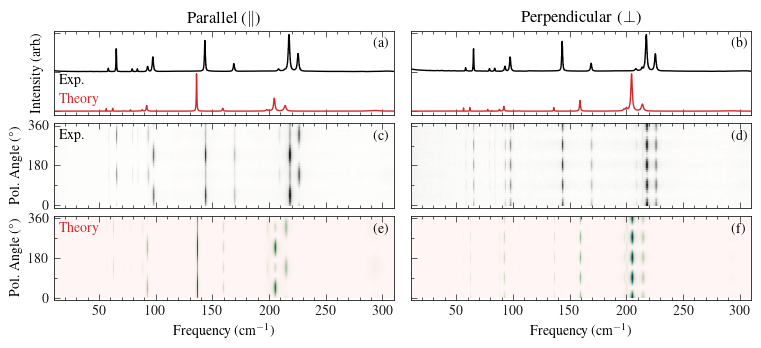

In [5]:
# with unpolarized spectra on semilogy


ds1 = ds_theory

fig, axs = plt.subplots(ncols=2, nrows=3, sharey="row", figsize=(9, 3.5), sharex="col")
fig.subplots_adjust(wspace=0.05, hspace=0.1)

xlim = (0, 300)

# exp
for ax, da in zip(axs[1, :], [da_para, da_perp]):
    # da = da - da.min()
    # da = da / da.sum()
    vmin = da.data.min()
    vmax = da.data.max()
    kw = {"vmin": vmin, "vmax": 1 * vmax, "clip": True}
    # norm = LogNorm(**kw)
    print(vmin, vmax)
    norm = Normalize(vmin=0, vmax=vmax)

    xr.plot.imshow(
        da,
        ax=ax,
        norm=norm,
        add_colorbar=False,
        add_labels=False,
        cmap=cmocean.cm.gray_r,
    )
    # ax.imshow(da.data, norm=norm) # , aspect="auto", origin="lower", extent=[0, 1000, 0, 90])

# unpolarized
for ax, _da in zip(axs[0], [da_para, da_perp]):
    # _da = _da - _da.min()
    # _da = _da / _da.sum()
    _da = _da.sum(dim="angle")
    _x = _da.frequency
    _y = normalize(_x, _da)
    # _y  = _da
    # ax.plot(_x, norm(_y), label=var, color="k", lw=1)
    ax.plot(_x, _y + 1, color="k", lw=1)


# theory
_ds = ds1
for ax, var in zip(axs[2], _ds.data_vars):
    da = _ds[var]
    # da['frequency']  = 1.065 * da['frequency']
    da = da - da.min()
    da = da / da.sum()
    vmin = da.data.min()
    vmax = da.data.max()
    # normalize integral to 1
    kw = {"vmin": 1e-5 * vmax, "vmax": 1 * vmax, "clip": False}
    norm = LogNorm(**kw)
    norm = Normalize(vmin=vmin, vmax=vmax)

    da = da.roll(angle=-45)

    xr.plot.imshow(
        da,
        ax=ax,
        norm=norm,
        add_colorbar=False,
        add_labels=False,
        cmap=cmocean.cm.tempo,
    )
    # ax.imshow(da.data, norm=norm, aspect="auto", origin="lower", extent=[0, 1000, 0, 90])
    ax.set_xlim(xlim)

# unpolarized
for ax, var in zip(axs[0], _ds.data_vars):
    _da = _ds[var].sum(dim="angle")
    # _da = _da - _da.min()
    # _da = _da / _da.sum()
    _x = _da.frequency
    _y = normalize(_x, _da)
    # _y  = _da
    # ax.plot(_x, norm(_y), label=var, color="C3", lw=1)
    ax.plot(_x, _y, label=var, color="C3", lw=1)

# labels
for ax in axs[1:, 0]:
    ax.set_ylabel("Pol. Angle (°)")  # , labelpad=10)

for ax in axs[2, :]:
    ax.set_xlabel("Frequency (cm$^{-1}$)")

ax = axs[0, 0]
ax.set_title(r"Parallel ($\parallel$)")

ax = axs[0, 1]
ax.set_title(r"Perpendicular ($\perp$)")

for ax in axs[1:, :].flatten():

    ax.set_ylim(-10, 370)

    xticks = np.arange(0, 301, 50)
    ax.set_xticks(xticks)
    xticks_minor = np.arange(*xlim, 10)
    ax.set_xticks(xticks_minor, minor=True)

    yticks = np.arange(0, 361, 180)
    ax.set_yticks(yticks, minor=False)

    yticks_minor = np.arange(0, 360, 90)
    ax.set_yticks(yticks_minor, minor=True)

    ax.tick_params(axis="both", direction="in", which="major", top=True, length=4)
    ax.tick_params(axis="both", direction="in", which="minor", top=True, length=2)

for ax in axs[0].flatten():

    # ax.set_yticks(yticks, minor=False)

    # yticks_minor = np.arange(0, 360, 45)
    # ax.set_yticks(yticks_minor, minor=True)
    # ax.set_ylim(-10, 2)

    ax.set_yticks([0, 1, 2])
    ax.set_yticklabels([])

    ax.tick_params(axis="both", direction="in", which="major", top=True, length=4)
    ax.tick_params(axis="both", direction="in", which="minor", top=True, length=2)


# label
ax = axs[0, 0]
ax.text(15, 0.7, "Exp.", color="k")
ax.text(15, 0.2, "Theory", color="C3")
ax = axs[1, 0]
ax.text(15, 340, "Exp.", va="top", color="k")
ax = axs[2, 0]
ax.text(15, 340, "Theory", va="top", color="C3")

axs[0, 0].set_ylabel("Intensity (arb.)")  #  , labelpad=25)

axs[0, 0].set_xlim(10, 310)
axs[0, 1].set_xlim(10, 310)

labels = [f"({x})" for x in "a b c d e f".split()]
for _ax, _l in zip(axs.flatten(), labels):
    _ax.text(292, 0.8 * _ax.get_ylim()[1], _l)

file = "plot_BZS_PO_101_total_linear.pdf"
fig.savefig(file)
fig.savefig(Path(file).stem + ".png")